# Figure 11.

Histograms of instantaneous TOA OLR values in (a, b) the full *HighRes* domain, sampled over 100 days, and (c, d) in the central part of the *HighRes* domain (shown by the blue box in Figs. 9 and 10), sampled over 10 days for (a) Trappist-1e and (b) Proxima b. Light blue bars show the global model values, while dark blue bars show *HighRes* model values

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

Import the necessary libraries.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime, timedelta

In [3]:
from fastprogress import progress_bar

In [4]:
import iris

import numpy as np

import matplotlib.pyplot as plt

In [5]:
from aeolus.coord_utils import UM_LATLON
from aeolus.core import Run
from aeolus.region import Region
from aeolus.subset import _dim_constr
from aeolus.util import fmt_lonlat, subplot_label_generator

In [6]:
from commons import (
    DT_FMT,
    GLM_RUNID,
    NS_COLORS,
    NS_MODEL_TYPES,
    NS_OUTPUT_NAME_PREFIX,
    NS_RUN_ALIASES,
    NS_RUNID,
    PLANET_ALIASES,
    SS_REGION,
)
import mypaths
from plot_func import use_style
from proc_um_output import process_cubes

Global stylesheet for figures.

In [7]:
use_style()

A few local definitions

In [8]:
model_label_aliases = {"global": "Global", "lam": "HighRes"}

In [9]:
FCST_PERIOD_CNSTR = iris.Constraint(forecast_period=lambda x: 9 < x < 15)

In [10]:
FCST_DIM_CNSTR = _dim_constr("forecast_period", strict=False)

Define two sampling methods: a large domain and the duration of 100 days, and a smaller domain with only the last 10 days.

In [11]:
# Simulation time (the UM simulation length is defined using real Earth dates,
# whose exact values obviously do not matter for exoplanets)

SAMPLE_METHODS = {
    "100day_full_domain": {
        "start": datetime(2009, 4, 28, 9, 0),
        "ndays": 100,
        "region": Region(-22, 42, -30, 30, "highres_domain"),
        "title": "Full HighRes domain,\nlast 100 days",
    },
    "10day_ss_region": {
        "start": datetime(2009, 7, 27, 9, 0),
        "ndays": 10,
        "region": SS_REGION,
        "title": "Subset of HighRes domain,\nlast 10 days",
    },
}

## Load data

Change file mask to load only the files with TOA radiation data.

In [12]:
NS_MODEL_TYPES["global"]["path"] = (
    NS_MODEL_TYPES["global"]["path"].parent / f"{GLM_RUNID}_pd*"
)
NS_MODEL_TYPES["lam"]["path"] = NS_MODEL_TYPES["lam"]["path"].parent / f"{NS_RUNID}_pa*"

Create a dictionary of `Run` objects with UM data.

In [13]:
runs = {}
for planet in progress_bar(PLANET_ALIASES.keys()):
    for run_key in progress_bar(NS_RUN_ALIASES.keys()):
        for model_type, model_specs in progress_bar(NS_MODEL_TYPES.items()):
            subdir = f"{planet}_{run_key}"
            for sm_key, sample_method in progress_bar(SAMPLE_METHODS.items()):
                label = f"{planet}_{run_key}_{model_type}_{sm_key}"
                flist = []
                for i in range(sample_method["ndays"]):
                    _cycle = (sample_method["start"] + timedelta(days=i)).strftime(
                        DT_FMT
                    )
                    flist.append(mypaths.nsdir / subdir / _cycle / model_specs["path"])
                # Load data
                run = Run(
                    files=flist,
                    name=label,
                    planet=planet,
                    model_type=model_type,
                    timestep=model_specs["timestep"],
                )
                # Regrid & interpolate data
                run.proc_data(
                    process_cubes,
                    timestep=run.timestep,
                    extract_mean=False,
                    regrid_multi_lev=False,
                )
                # Select domain
                run.proc = run.proc.extract(sample_method["region"].constraint)
                # Save to dict
                runs[label] = run

## Calculate the distribution of TOA OLR

In [14]:
varname = "toa_outgoing_longwave_flux"
short_name = "TOA OLR"
tex_units = "$W$ $m^{-2}$"

Define histogram bins

In [15]:
bin_step = 5
bins = np.arange(50, 301, bin_step)
bin_mid = (bins[:-1] + bins[1:]) * 0.5

Calculate a histogram for each of the simulations.

In [16]:
hist_dict = {}
for planet in PLANET_ALIASES.keys():
    hist_dict[planet] = {}
    for run_key in NS_RUN_ALIASES.keys():
        hist_dict[planet][run_key] = {}
        for model_type in NS_MODEL_TYPES.keys():
            hist_dict[planet][run_key][model_type] = {}
            for sm_key, sample_method in SAMPLE_METHODS.items():
                label = f"{planet}_{run_key}_{model_type}_{sm_key}"
                cube = (
                    runs[label].proc.extract(FCST_PERIOD_CNSTR).extract_strict(varname)
                )
                ntimes = cube.coord("time").shape[-1]
                arr = cube.data
                tot_pnts = arr.size
                hist, _ = np.histogram(arr.ravel(), bins=bins)
                hist_dict[planet][run_key][model_type][sm_key] = hist / tot_pnts * 100

## Plot the results

Create a plot

In [17]:
ncol = len(PLANET_ALIASES)
nrow = len(SAMPLE_METHODS)

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(8 * ncol, 4 * nrow))

iletters = subplot_label_generator()
for (sm_key, sample_method), axrow in zip(SAMPLE_METHODS.items(), axs):
    for i, (planet, ax) in enumerate(zip(PLANET_ALIASES, axrow)):
        ax.set_title(f"({next(iletters)})", fontsize="small", pad=5, loc="left")
        ax.set_title(sample_method["title"], fontsize="small", pad=5, loc="right")
        if ax.is_first_row():
            ax.set_title(PLANET_ALIASES[planet], fontsize="large", pad=5, loc="center")
        if ax.is_first_col():
            ax.set_ylabel("[% of grid points]")
        if ax.is_last_row():
            ax.set_xlabel(f"{short_name} within the substellar region [{tex_units}]")

        for run_key in NS_RUN_ALIASES.keys():
            for model_type in NS_MODEL_TYPES.keys():

                ax.bar(
                    bin_mid,
                    hist_dict[planet][run_key][model_type][sm_key],
                    width=bin_step,
                    alpha=0.5,
                    color=NS_COLORS[run_key][model_type],
                    label=model_label_aliases[model_type],
                )

        ax.set_xlim(bins[0], bins[-1])
        ax.set_xticks(bins[::5])

ax = axs.flatten()[-1]
leg = ax.legend(loc="upper right")

plt.subplots_adjust(wspace=0.1, hspace=0.25)
plt.close()  # Show the figure in a separate cell

## Show the figure

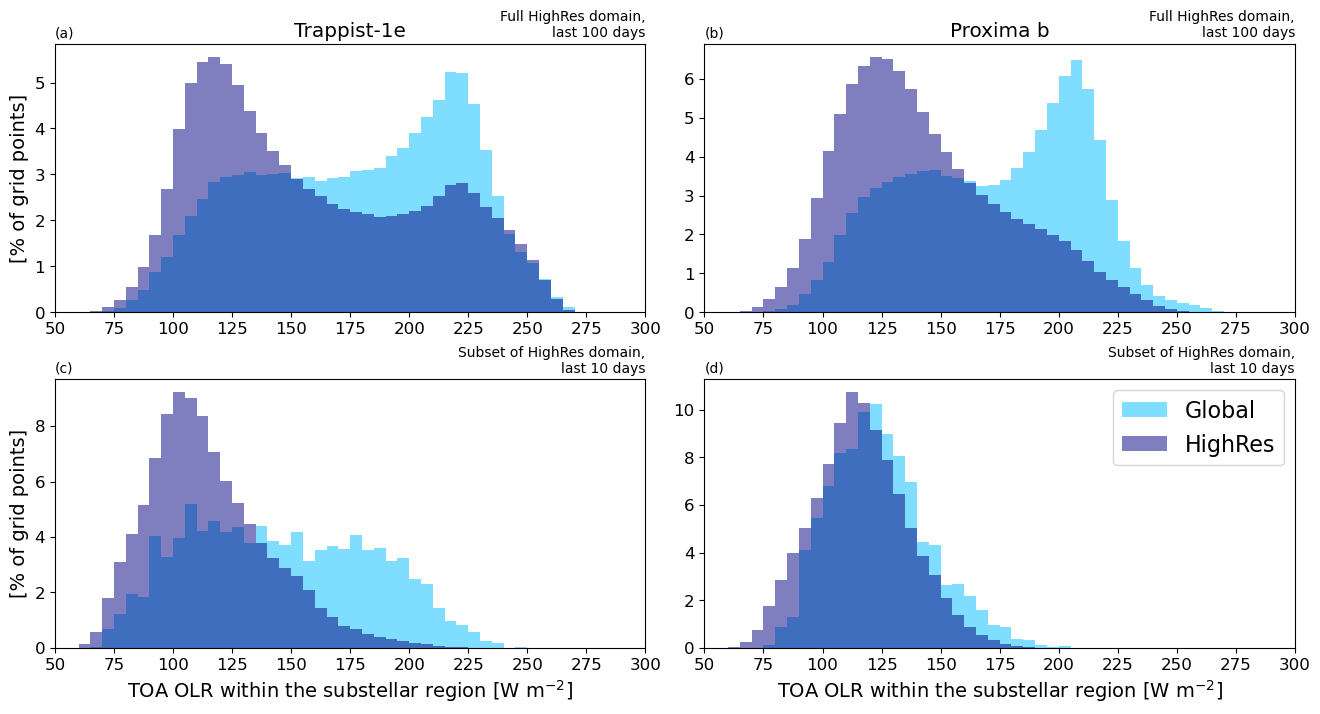

In [18]:
fig

And save it.

In [19]:
imgname = mypaths.plotdir / f"{NS_OUTPUT_NAME_PREFIX}__toa_olr_hist.png"

In [20]:
fig.savefig(imgname, dpi=200)
print(f"Saved to ../{imgname.relative_to(mypaths.topdir)}")

Saved to ../plots/trap1e_proxb__grcs__toa_olr_hist.png
